In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#from nltk.stem import LancasterStemmer,WordNetLemmatizer

from bs4 import BeautifulSoup
import re,string,unicodedata, copy
import random

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from collections import Counter

np.random.seed(0)


# Load Dataset

In [2]:
imdb_data=pd.read_csv('IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


# Text Preprocessing

### Denoising the text:
remove HTML tags, square brackets, punctuations and special characters.

### Remove Stopwords:
remove words which do not add useful information to the classifier.

In [4]:
#Removing all the noise
def denoise_text(text):
    #remove html strips
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    #remove square brackets
    text = re.sub('\[[^]]*\]', '', text)
    #replace punctuation with space
    text = re.sub(r'[,.;@#?!&$\-]+\ *', ' ', text, flags=re.VERBOSE)
    #remove special characters
    text=re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text.lower()

imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [5]:
print('Sample Text after denoising:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after denoising:


'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done '

In [6]:
#text tokenizer
tokenizer=ToktokTokenizer()

#get list of stopwords
stop=set([re.sub(r'[^a-zA-z0-9\s]', '', st) for st in stopwords.words('english')])

#removing the stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

In [7]:
print('Sample Text after filtering:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after filtering:


'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

In [8]:
'''Additional preprocessing'''
#stem the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [9]:
print('Sample Text after stemming:')
print('='*70)
imdb_data.iloc[1,0]

Sample Text after stemming:


'wonder littl product film techniqu unassum old time bbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [10]:
imdb_data['sentiment'] = imdb_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Exploratory Data Analysis

C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


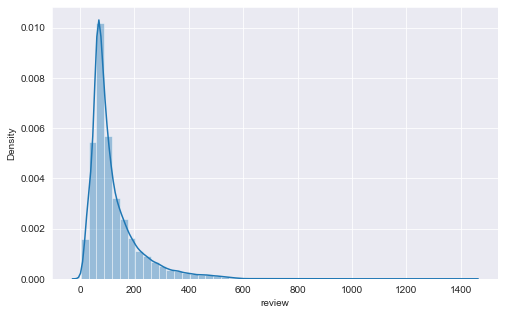

In [11]:
seqlen = imdb_data['review'].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

fig = seqlen_plot.get_figure()
fig.savefig("seqlen_plot.png")

<function matplotlib.pyplot.show(close=None, block=None)>

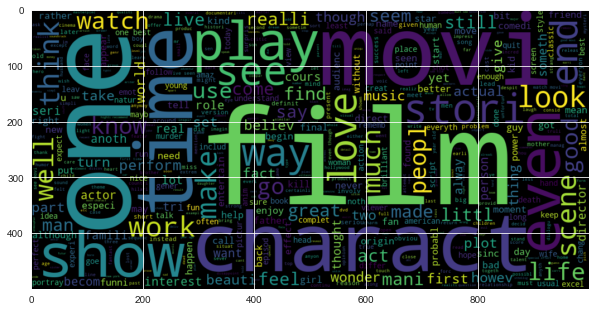

In [12]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=' '.join(imdb_data[imdb_data['sentiment']==1].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

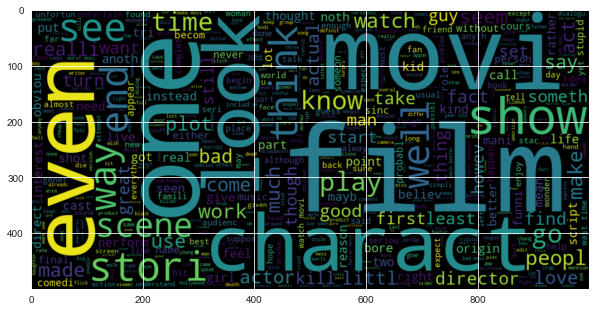

In [13]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=' '.join(imdb_data[imdb_data['sentiment']==0].review.tolist())
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

In [14]:

train_imdb, test_imdb = train_test_split(imdb_data,test_size = 0.3)
x_train,y_train,x_test,y_test = train_imdb['review'].values,train_imdb['sentiment'].values,test_imdb['review'].values,test_imdb['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 35000 samples
Test data has 15000 samples


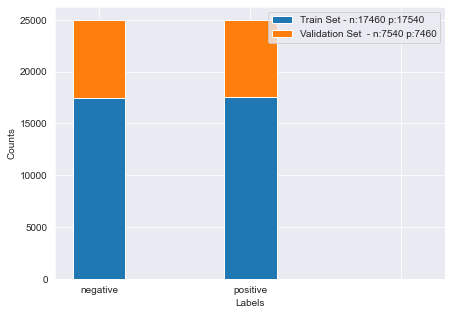

In [15]:
train = (pd.DataFrame(data = y_train).value_counts()[0],pd.DataFrame(data = y_train).value_counts()[1], 0)
valid = (pd.DataFrame(data = y_test).value_counts()[0],pd.DataFrame(data = y_test).value_counts()[1],0)

ind = np.arange(3)
width = 0.35

fig = plt.subplots(figsize=(7,5))
p1 = plt.bar(ind, train, width)
p2 = plt.bar(ind, valid, width, bottom=train)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.xticks(ind, ('negative','positive', None))
plt.legend((p1[0],p2[0]),('Train Set - n:'+str(train[0])+' p:'+str(train[1]), 'Validation Set  - n:'+str(valid[0])+' p:'+str(valid[1])), loc = 'upper right')
plt.show()

In [75]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)

TfidfVectorizer()

In [80]:
word_list = []

for sent in x_train:
    for word in sent.split():
        if word != '':
            word_list.append(word)

#make vocab dictionary
corpus = Counter(word_list)
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:5000]

#transform courpus to tfidf vector
vocabvec = vectorizer.transform(np.array(corpus_))

In [19]:
print(f'Length of vocabulary is {len(corpus_)}')

Length of vocabulary is 1000


C:\Users\sayan\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


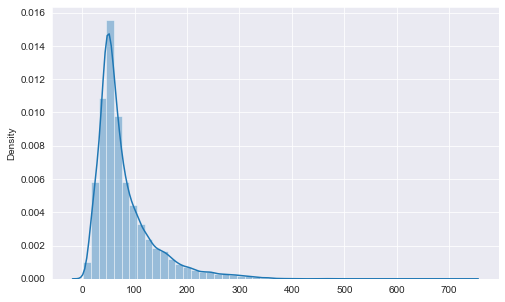

In [20]:
rev_len = [len(i) for i in x_train]
seqlen = pd.Series(rev_len)
sns.set_style('darkgrid')
plt.figure(figsize = (8, 5))
seqlen_plot = sns.distplot(seqlen)

In [21]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).describe()

count    35000.000000
mean        79.386943
std         55.595568
min          2.000000
25%         45.000000
50%         61.000000
75%         97.000000
max        735.000000
dtype: float64

In [77]:
#naive bayes
from sklearn.naive_bayes import MultinomialNB

In [97]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
clf.score(x_test1, y_test)

0.8626666666666667

In [98]:
#generate probabilities of a word in corpus being neg or pos
proba = clf.predict_proba(vocabvec)

In [100]:
from collections import defaultdict
pos_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    pos_vocab[w] = proba[i][1] 

neg_vocab = defaultdict(list)

for i, w in enumerate(corpus_):
    neg_vocab[w] = proba[i][0] 

In [101]:
pos_vocab

defaultdict(list,
            {'movi': 0.437452417678507,
             'film': 0.5215354342672692,
             'one': 0.4994840928246509,
             'like': 0.4549479426978326,
             'time': 0.5105256767098817,
             'good': 0.5061861017192384,
             'make': 0.4452187463596512,
             'see': 0.5412634001032531,
             'charact': 0.48979065745731337,
             'watch': 0.46093500635519735,
             'get': 0.45169775647063043,
             'even': 0.3708815000975163,
             'stori': 0.5557382541659874,
             'would': 0.42075608579263873,
             'realli': 0.4734004465769407,
             'well': 0.6037675122686269,
             'scene': 0.46076031660986155,
             'look': 0.40551447332877216,
             'show': 0.569804440058484,
             'much': 0.46145637403165674,
             'end': 0.4768319347288952,
             'bad': 0.1795015557851493,
             'great': 0.72960384312596,
             'love': 0.70060711

# Discriminative Process for classification

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [22]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train.astype('int')))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test.astype('int')))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [23]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input features: \n', sample_x)
print('Sample input labels: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input features: 
 tensor([[  0,   0,   0,  ..., 206,  11,  15],
        [383, 318,  73,  ..., 329,  63, 728],
        [  0,   0,   0,  ..., 369, 989, 215],
        ...,
        [549,  42, 402,  ...,  32, 208, 981],
        [  0,   0,   0,  ...,  35,  30, 525],
        [  0,   0,   0,  ...,  51,   2, 173]])
Sample input labels: 
 tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1])


### LSTM neural network model

In [24]:
class LSTMClassifier(nn.Module):
    def __init__(self,n_layers,vocab_size,hidden_dim,embedding_dim):
        super(LSTMClassifier,self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.n_layers = n_layers
        self.vocab_size = vocab_size

        #embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = torch.nn.LSTM(input_size = embedding_dim, 
                                 hidden_size = self.hidden_dim,
                                 num_layers = self.n_layers, 
                                 batch_first = True,
                                 dropout = 0.2)

        # dropout layer
        self.dropout = nn.Dropout(0.3)
        #linear layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = torch.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] 
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.n_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden
        

In [25]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [26]:
n_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 100
output_dim = 1
hidden_dim = 256


model = LSTMClassifier(n_layers,vocab_size,hidden_dim,embedding_dim)

#moving to gpu
model.to(device)

print(model)


LSTMClassifier(
  (embedding): Embedding(1001, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [27]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [28]:
clip = 5
epochs = 5
best_loss = float('inf')
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        if inputs.shape[0] != 50:
            break
        
        inputs, labels = inputs.to(device), labels.to(device) 
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # get accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        # prevent the exploding gradient in LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())
        
        accuracy = acc(output,labels)
        val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} | Valid Loss: {:.4f} | Train Acc: {:.2f} | Valid Acc: {:.2f}".format(epoch+1,
    epochs, epoch_train_loss, epoch_val_loss, epoch_train_acc*100, epoch_val_acc*100)
    print(to_print)
    if epoch_val_loss <= best_loss:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_loss,epoch_val_loss))
        best_loss = epoch_val_loss
        best_model = copy.deepcopy(model)
    print(70*'==')


Epoch[1/5], Train Loss: 0.5323 | Valid Loss: 0.4731 | Train Acc: 73.84 | Valid Acc: 77.89
Validation loss decreased (inf --> 0.473119).  Saving model ...
Epoch[2/5], Train Loss: 0.4047 | Valid Loss: 0.3785 | Train Acc: 82.25 | Valid Acc: 83.24
Validation loss decreased (0.473119 --> 0.378459).  Saving model ...
Epoch[3/5], Train Loss: 0.3628 | Valid Loss: 0.3691 | Train Acc: 84.30 | Valid Acc: 83.91
Validation loss decreased (0.378459 --> 0.369136).  Saving model ...
Epoch[4/5], Train Loss: 0.3211 | Valid Loss: 0.3481 | Train Acc: 86.39 | Valid Acc: 84.71
Validation loss decreased (0.369136 --> 0.348079).  Saving model ...
Epoch[5/5], Train Loss: 0.2923 | Valid Loss: 0.3458 | Train Acc: 87.74 | Valid Acc: 84.73
Validation loss decreased (0.348079 --> 0.345838).  Saving model ...


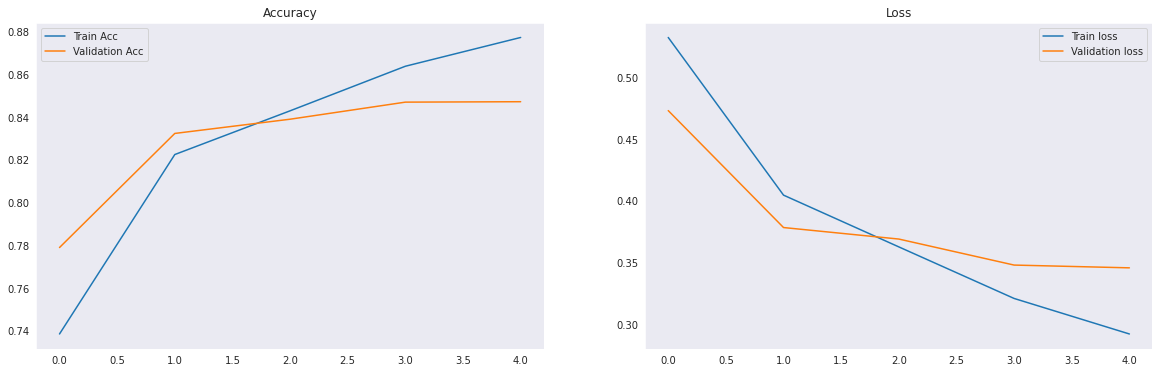

In [29]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [30]:
nb_classes = 2
conf_matrix = torch.zeros(nb_classes,nb_classes)
y_predictions = np.array([])
y_proba = np.array([])
y_truths = np.array([])
i=0

val_h = best_model.init_hidden(batch_size)
val_acc = 0.0
model.eval()
with torch.no_grad():
    for inputs, ytrue in valid_loader:
        if inputs.shape[0] != 50:
            break
        val_h = tuple([each.data for each in val_h])

        inputs, ytrue = inputs.to(device), ytrue.to(device)
        y_truths = np.append(y_truths,ytrue.cpu().numpy())
        ypred, val_h = best_model(inputs, val_h)
        preds = (ypred>0.5)*1
        y_predictions = np.append(y_predictions, preds.cpu().numpy())
        accuracy = acc(ypred,ytrue)
        val_acc += accuracy
        if i==0:
            y_proba = ypred.cpu().numpy()
        else:
            y_proba = np.append(y_proba, ypred.cpu().numpy(), axis = 0)
        i+=1

conf_matrix = confusion_matrix(y_truths, y_predictions)
print("Test Accuracy: {:.2f}".format(val_acc*100/len(valid_loader.dataset)))

/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Test Accuracy: 84.61


Text(0.5, 1.0, 'class 0 (specificity): 0.855 | class 1 (sensitivity): 0.837')

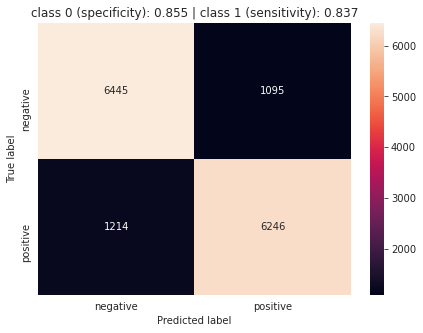

In [31]:
accs = (np.diag(conf_matrix)/conf_matrix.sum(1))
df_cm = pd.DataFrame(conf_matrix, index = [i for i in ['negative','positive']],
                  columns = [i for i in ['negative','positive']])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt = 'g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('class 0 (specificity): {:0.3f} | class 1 (sensitivity): {:0.3f}'.format(accs[0],accs[1]))

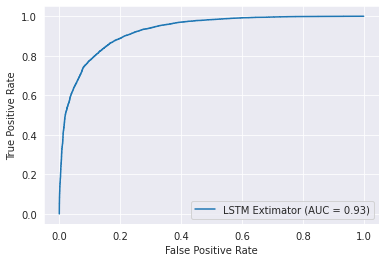

In [32]:
from sklearn import metrics

fpr, tpr, thrs = metrics.roc_curve(y_truths, y_proba[:])
roc_auc = metrics.auc(fpr,tpr)
display1 = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'LSTM Extimator')
display1.plot()
plt.show()

In [33]:
x_test_real,y_test_real = test_imdb['review'].values,test_imdb['sentiment'].values

def tokenize_test(x_test_real, vocab):
    test_sent=[]
    for sent in x_test_real:
        test_sent.append([vocab[word] for word in sent.split() if word in vocab.keys()])
    return np.array(test_sent)

x_test_real = tokenize_test(x_test_real, vocab)

<ipython-input-33-08acce9c61e5>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(test_sent)


In [34]:
def predict_text(text):
        word_seq = np.array([vocab[word] for word in text.split() 
                         if word in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,80))
        inputs = pad.to(device)
        batch_size = 1
        h = best_model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = best_model(inputs, h)
        return(output.item())

sentiment_dict = {1:'positive', 0:'negtive'}

In [35]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

john travolta repris role chili palmer hollywood gangster turn eye music busi use negoti skill tri run independ record label wife murder friend play uma thurman tri get young singer christina milian hit record saw sequel heard terribl film howev cool still enjoy comedi even good origin movi focus music industri time around instead movi industri music busi portray poorli movi use bunch lame stereotyp cant tell intent sinc get shorti nice job spoof movi industri cant said sequel attempt come lazi impress cast save movi sink best perform given rock nice see differ type role vinc vaughn also give funni perform though start get annoy end surprisingli uma thurman give averag perform expect john travolta return chili okay job perform kind dull though christina milian give horribl perform also good singer cedric entertain give good perform though film long also bunch cameo includ steven tyler jame wood f gari gray direct poor job handl film well movi kind mess also ton product placement got an

/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [36]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

ah best funniest movi femal footbal fan slightli better 1982 saga teenag delus set north london qv way watch film 4 ru inabl set pvr easili second favourit footbal movi mike bassett england manag time ad twist look like guerrilla piec movi make team appar keep make movi ban countri made think bit girl taken stadium sun set fast reaction round rare movi make laugh loud rural soldier escort one girl lavvi forc wear inpromptu mask made poster ali daei stop wake other hous snort especi young soldier misunderstood grandfath call assist speak toilet wish could speak farsi could work write toilet wall ye scribbl roman script mostli refer wanki american rock band also rural farsi theme reckon omid djalili sound like yokel talk farsi listen custodi sergeant movi go yup im go bore sexual polit iran im go bore dubiou act love movi come script edit top notch stuff here list top favourit footbal movi 1 mike bassett england manag 2 offsid 3 glori glori day 4 shot glori 5 arsen stadium mysteri
Actual

In [37]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

upon time castl two littl girl play garden castl sister blond littl girl kitti brunett one evelyn evelyn steal kitti doll kitti pursu evelyn run long corridor reach room grandfath sit armchair read newspap kitti complain evelyn evelyn look interestedli pictur hang wall evelyn begin say repeatedli red ladi kitti black ladi suddenli evelyn grab dagger lie nearbi stab kitti doll cut doll head fight ensu evelyn almost use dagger kitti grandfath interven worst avoid later grandfath tell legend relat pictur hang wall front ladi dress black stab ladi dress reda long time ago red ladi black ladi live castl sister hate one night jealousi reason black ladi enter red ladi room stab seven time one year later red ladi left grave kill six innoc peopl seventh victim black ladi everi hundr year event repeat castl red ladi kill six innoc victim kill black ladi grandfath end tale say accord legend sixteen year red queen come kill seven time assur old legend sixteen year pass begin film mani twist surpri

In [38]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

film joke comedi sure seriou thriller suggest intend humor quit occas poor act poor direct appal script audienc laugh loud cinema plot accept promis young artist reach peak shot dead assassin walk mistak killer see young artist work portfolio carri decid attend exhibit work exhibit assassin meet dead artist sister end fall love predict stuff end anyon guess poorli script film take place mainli around vienna austria show beauti citi wast time film though unless studi act direct script film
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.9953364250250161


In [39]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

watch ton movi idea would good look forward read plot even though find nirvana overr sound like would ton fun jansen put littl touch like book kubrick book among other movi poster etc like see director take time put heart film realli feel ton scene moment love tri think film like would say thing think cameron crow film take littl moment make stand special soundtrack amaz song work perfectli scene feel film film amazingli shot edit outstand could realli go film cannot recommend enough realli want fun stori great tune director clearli put heart work check
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.935280978679657


In [40]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

difficult decid whether movi suffer crap dialogu made appear crap actor case suffer storywrit mediocr best although made late 80 first part movi play like 60 teenag screwbal comedi bar absenc actual humour especi part good girl annoy dori day figur could hopefear includ slightli whini opposit anyth fun friend want net effect start hope shell bite listen voic anymor profan gratuit nuditi plu realli 80 style cloth clue movi made 80 oh pretti passabl music storywis pretti formula stuff bunch horni apart obvious miss nice girl teenag decid celebr halloween night throw parti haunt hous parti fornic ensu along ill advis seanc kick demon possess spree subject movi suspens part tri guess order charact expir sure care whether actor bad becom demonszombiesdinn actual improv perform somewhat ridicul clich dialogu annoy squirm seat gorewis flick aint nuthin special unless think cheesi kind special exampl demon head occasion appear screamingli fake wonder 5 year old trick treat say there noth enjoy

In [41]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

believ wast money rent movi thought porn flick start never got better act music drown actor horribl save money read movi way b\c knew music would drown speak line never got part slaughterhous need continu show cow pig butcher real btk killer understand famou actors\actress movi script would turn away within first page read would better watch paint dri
Actual sentiment is  : negtive
Predicted sentiment is negative with a probability of 0.9928536526858807


In [42]:
index = random.randint(0, 15000)
print(test_imdb['review'].iloc[index])
print('='*70)
print(f'Actual sentiment is  : {sentiment_dict[test_imdb["sentiment"].iloc[index]]}')
print('='*70)
pro = predict_text(test_imdb['review'].iloc[index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

consid great admir david lynch work provid viewer absolut uniqu motion pictur typic lynch element seen work naiv thought could predict lynch next step dead wrong dumbland someth could never imagin name david lynch still recoveri first shock start contempl extrem primit main charact drew conclus absurd cruelti brutal disgust present mirror bit realiti emphas distort thing live hardli ever emphas either disgust horribl howev surround us take courag say dumbland focus bit piec movi enjoy though sometim laugh strang pervert sens humor anim reflect thing rather reject observ simplic morbid absurd take like exist final attent enough find element typic lynch well recommend toler peopl
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.8426421284675598
